# Introduction

With this repository I wanted to challenge myself on the task of creating a model which is able to the determine correctly the demand planning.

The repository contains 2 notebooks, this being the first.

In the first notebook I tried to use linear models by applying log transformations to the numerical features to normalize the distribution.
The linear models reached a score of 78%.

After this I decided to use XGBoost and LightGBMR which handle skewed or not normal distributions without issues and focused on feature engineering concerning more metrics which would capture more complex relationship among features, e.g. average sales per week/ month/ etc.

This led to a 92% precision from XGBoost and 91% from LightGBMR, both good results.

The model could be improved with further feature engineering but can be use already as the performance is high.

Business use of this model could be demand planning in E-commerce if we think about replenishment business models in which suppliers inject their items within the service provider's warehouse, allowing the E-commerce platform to plan the units to be ordered from the suppliers to meet the correct level of demand and not having items which would remain unsold, wasting therefore space in the warehouse and also increasing storage cost for the suppliers.

**Please review the second notebook to find the results of XGBoost and LightGBMR.**

In [170]:
#importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

In [171]:
data1 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Demand_Forecasting/train_0irEZ2H.csv')
data2 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Demand_Forecasting/test_nfaJ3J5.csv')

train = data1.copy()
test = data2.copy()

train.shape, test.shape

((150150, 9), (13860, 8))

In [172]:
train.sample(10)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
101654,143908,25/09/12,8095,217390,139.6500,166.0125,0,0,195
8002,11320,28/02/11,9881,378934,177.4125,205.9125,0,0,20
147661,209115,25/06/13,9809,222765,190.9500,254.3625,1,1,207
112923,159918,27/11/12,9745,547934,177.4125,177.4125,0,0,31
65044,92043,13/02/12,9092,216233,115.4250,115.4250,0,0,33
58629,82955,02/01/12,9745,219009,210.1875,210.1875,0,0,51
75083,106240,17/04/12,8091,223153,213.0375,213.0375,0,0,29
60330,85355,16/01/12,8555,223153,201.6375,201.6375,0,0,26
81712,115641,22/05/12,9731,216418,106.8750,106.8750,0,0,62
15853,22425,18/04/11,9680,223153,212.3250,212.3250,0,0,7


In [173]:
num = train.select_dtypes(include='number')
cat = train.select_dtypes(exclude='number')

num.columns, cat.columns

(Index(['record_ID', 'store_id', 'sku_id', 'total_price', 'base_price',
        'is_featured_sku', 'is_display_sku', 'units_sold'],
       dtype='object'),
 Index(['week'], dtype='object'))

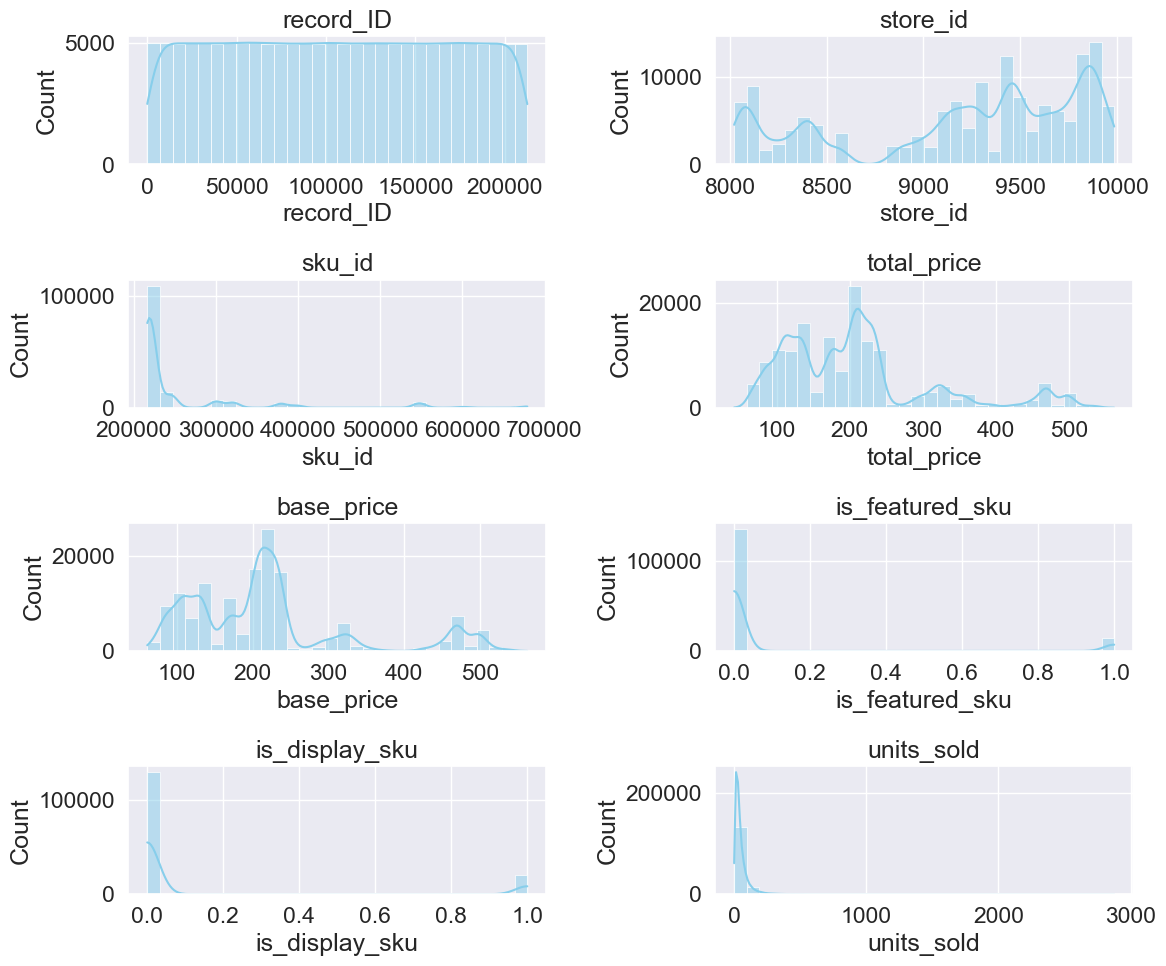

In [174]:
num1 = num.copy()

plt.figure(figsize=(12,10))

for i, column in enumerate(num1, 1):
    plt.subplot(4, 2, i)
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()


In [175]:
#visualizing the average sales for featured and displayed SKUs

featured_skus = train.groupby('is_featured_sku')['units_sold'].mean()

featured_skus

is_featured_sku
0     45.062330
1    114.216216
Name: units_sold, dtype: float64

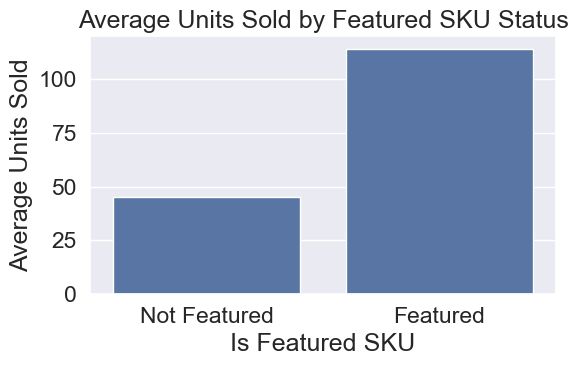

In [176]:
featured_skus_df = featured_skus.reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='is_featured_sku', y='units_sold', data=featured_skus_df)

plt.title('Average Units Sold by Featured SKU Status')
plt.xlabel('Is Featured SKU')
plt.ylabel('Average Units Sold')
plt.xticks([0, 1], ['Not Featured', 'Featured'])
plt.tight_layout()
plt.show()

In [177]:
displayed_skus = train.groupby('is_display_sku')['units_sold'].mean()

displayed_skus

is_display_sku
0     43.114721
1    107.375050
Name: units_sold, dtype: float64

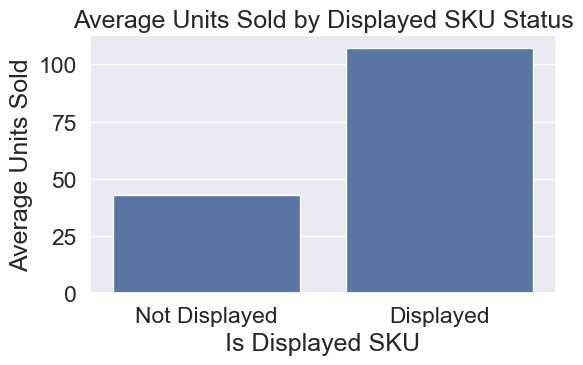

In [178]:
displayed_skus_df = displayed_skus.reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='is_display_sku', y='units_sold', data=displayed_skus_df)

plt.title('Average Units Sold by Displayed SKU Status')
plt.xlabel('Is Displayed SKU')
plt.ylabel('Average Units Sold')
plt.xticks([0, 1], ['Not Displayed', 'Displayed'])
plt.tight_layout()
plt.show()

# Feature engineering

In [179]:
train['price_diff'] = train['base_price'] - train['total_price']
test['price_diff'] = test['base_price'] - test['total_price']

train['discount_applied'] = (train['price_diff'] / 100.0) * train['base_price']
test['discount_applied'] = (test['price_diff'] / 100.0) * test['base_price']

train['store_sku_id'] = str(train['store_id']) + '_' + str(train['sku_id'])
test['store_sku_id'] = str(test['store_id']) + '_' + str(test['sku_id'])

print('First 3 rows of Train after feature engineering: \n', train.head(3))
print('First 3 rows of Test after feature engineering: \n', test.head(3))



First 3 rows of Train after feature engineering: 
    record_ID      week  store_id  sku_id  total_price  base_price  \
0          1  17/01/11      8091  216418      99.0375    111.8625   
1          2  17/01/11      8091  216419      99.0375     99.0375   
2          3  17/01/11      8091  216425     133.9500    133.9500   

   is_featured_sku  is_display_sku  units_sold  price_diff  discount_applied  \
0                0               0          20      12.825         14.346366   
1                0               0          28       0.000          0.000000   
2                0               0          19       0.000          0.000000   

                                                                                                                                                                                                                                                                                                                                                               

In [180]:
train['store_sku'] = (train['store_id'].astype('str') + "_" + train['sku_id'].astype('str'))
test['store_sku'] = (test['store_id'].astype('str') + "_" + test['sku_id'].astype('str'))
train = train.drop(columns='store_sku_id')
test = test.drop(columns='store_sku_id')

In [181]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   record_ID         150150 non-null  int64  
 1   week              150150 non-null  object 
 2   store_id          150150 non-null  int64  
 3   sku_id            150150 non-null  int64  
 4   total_price       150149 non-null  float64
 5   base_price        150150 non-null  float64
 6   is_featured_sku   150150 non-null  int64  
 7   is_display_sku    150150 non-null  int64  
 8   units_sold        150150 non-null  int64  
 9   price_diff        150149 non-null  float64
 10  discount_applied  150149 non-null  float64
 11  store_sku         150150 non-null  object 
dtypes: float64(4), int64(6), object(2)
memory usage: 13.7+ MB


In [182]:
#datetime feature engineering

import datetime

train['week'] = pd.to_datetime(train['week'])
test['week'] = pd.to_datetime(test['week'])

train['year'] = train['week'].dt.year
test['year'] = test['week'].dt.year
train['month'] = train['week'].dt.month
test['month'] = test['week'].dt.month
train['weekday'] = train['week'].dt.day_of_week
test['weekday'] = test['week'].dt.day_of_week
train['week_of_year'] = train['week'].dt.isocalendar().week
test['week_of_year'] = test['week'].dt.isocalendar().week


In [183]:
days_map = {
    0 : 1,
    1 : 2,
    2 : 3,
    3 : 4,
    4 : 5,
    5 : 6,
    6 : 7
}

train['weekday'] = train['weekday'].map(days_map)
test['weekday'] = test['weekday'].map(days_map)

train

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,price_diff,discount_applied,store_sku,year,month,weekday,week_of_year
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,12.8250,14.346366,8091_216418,2011,1,1,3
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,0.0000,0.000000,8091_216419,2011,1,1,3
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,0.0000,0.000000,8091_216425,2011,1,1,3
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,0.0000,0.000000,8091_216233,2011,1,1,3
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,0.0000,0.000000,8091_217390,2011,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38,0.0000,0.000000,9984_223245,2013,9,6,36
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30,0.0000,0.000000,9984_223153,2013,9,6,36
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31,126.1125,610.116511,9984_245338,2013,9,6,36
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12,49.8750,95.591672,9984_547934,2013,9,6,36


In [184]:
train = train.rename(columns={'week' : 'date'})
test = test.rename(columns={'week' : 'date'})

train

,record_ID,date,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,price_diff,discount_applied,store_sku,year,month,weekday,week_of_year
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,12.8250,14.346366,8091_216418,2011,1,1,3
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,0.0000,0.000000,8091_216419,2011,1,1,3
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,0.0000,0.000000,8091_216425,2011,1,1,3
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,0.0000,0.000000,8091_216233,2011,1,1,3
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,0.0000,0.000000,8091_217390,2011,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,9984,223245,235.8375,235.8375,0,0,38,0.0000,0.000000,9984_223245,2013,9,6,36
150146,212639,2013-09-07,9984,223153,235.8375,235.8375,0,0,30,0.0000,0.000000,9984_223153,2013,9,6,36
150147,212642,2013-09-07,9984,245338,357.6750,483.7875,1,1,31,126.1125,610.116511,9984_245338,2013,9,6,36
150148,212643,2013-09-07,9984,547934,141.7875,191.6625,0,1,12,49.8750,95.591672,9984_547934,2013,9,6,36


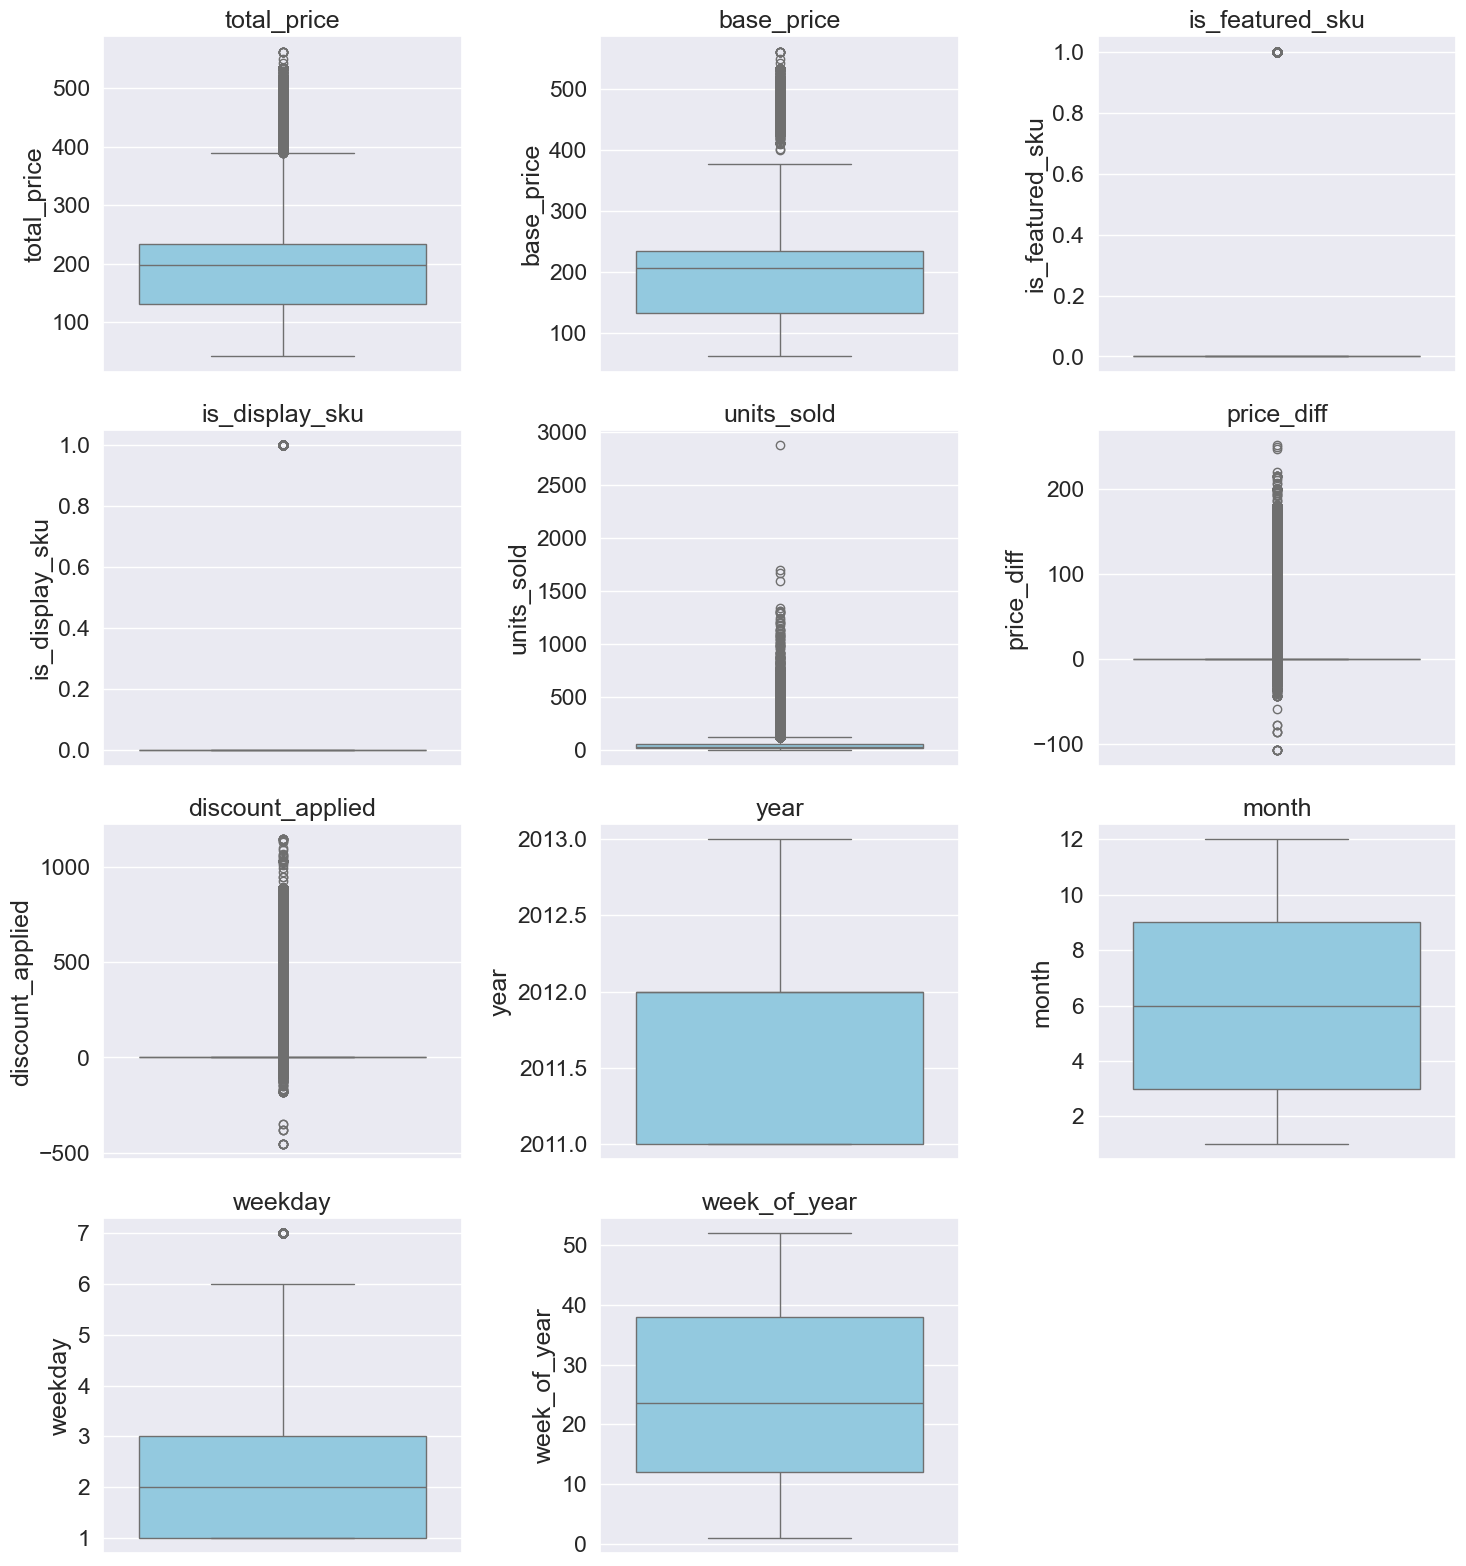

In [185]:
boxplot_cols = [
    'total_price', 'base_price', 'is_featured_sku', 'is_display_sku',
    'units_sold', 'price_diff', 'discount_applied', 'year',
    'month', 'weekday', 'week_of_year'
]

n_cols = 3
n_rows = (len(boxplot_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(boxplot_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=train[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()

plt.show()

In [186]:
train.shape

(150150, 16)

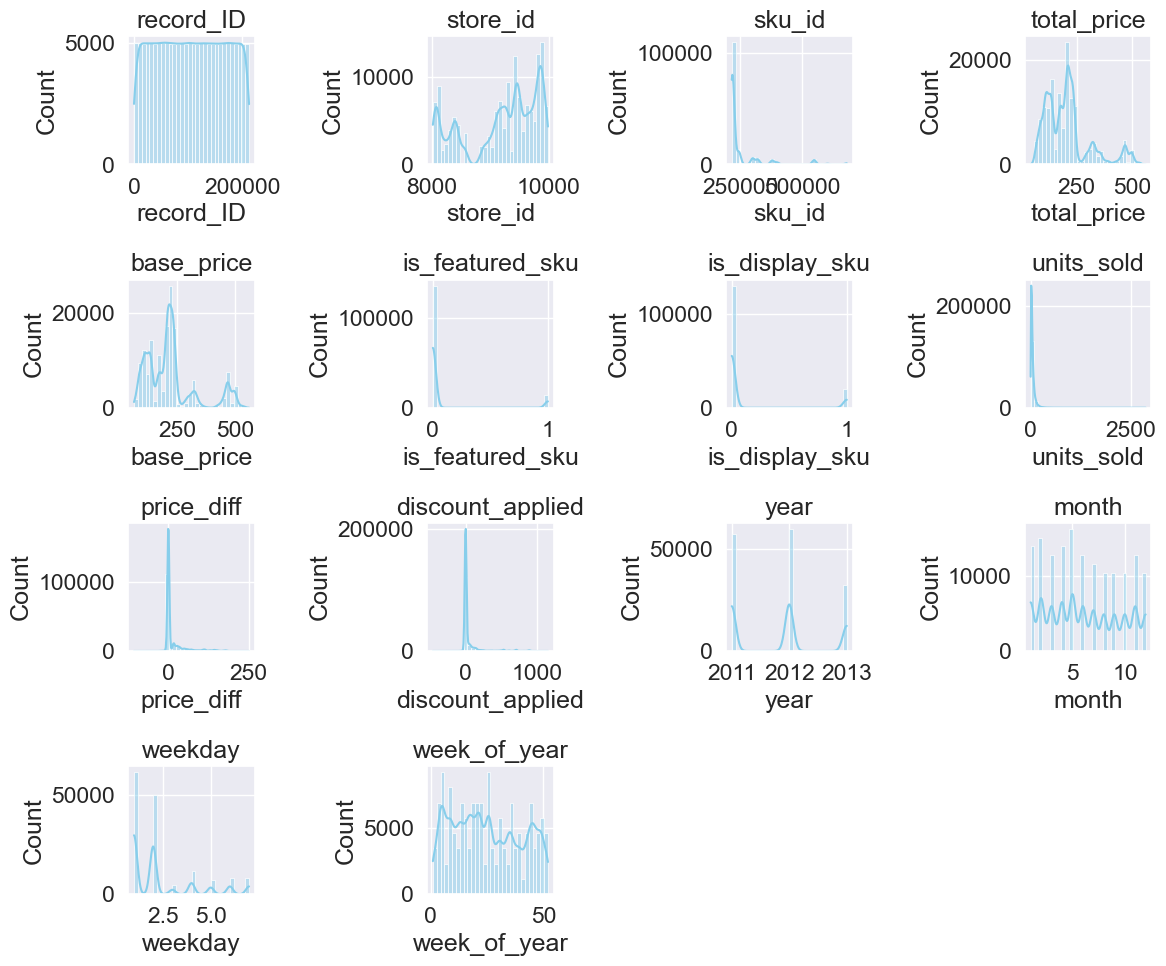

In [187]:
num = train.select_dtypes(include='number')
num1 = num.copy()

plt.figure(figsize=(12,10))

for i, column in enumerate(num1, 1):
    plt.subplot(4, 4, i)
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()


In [188]:
train['units_sold_log'] = np.log(train['units_sold'] + 1)

train['total_price_log'] = np.log(train['total_price'] + 1)
test['total_price_log'] = np.log(test['total_price'] + 1)

train['base_price_log'] = np.log(train['base_price'] + 1)
test['base_price_log'] = np.log(test['base_price'] + 1)

train['price_diff_log'] = np.log(train['price_diff'] + 1)
test['price_diff_log'] = np.log(test['price_diff'] + 1)

train['discount_applied_log'] = np.log(train['discount_applied'] + 1)
test['discount_applied_log'] = np.log(test['discount_applied'] + 1)

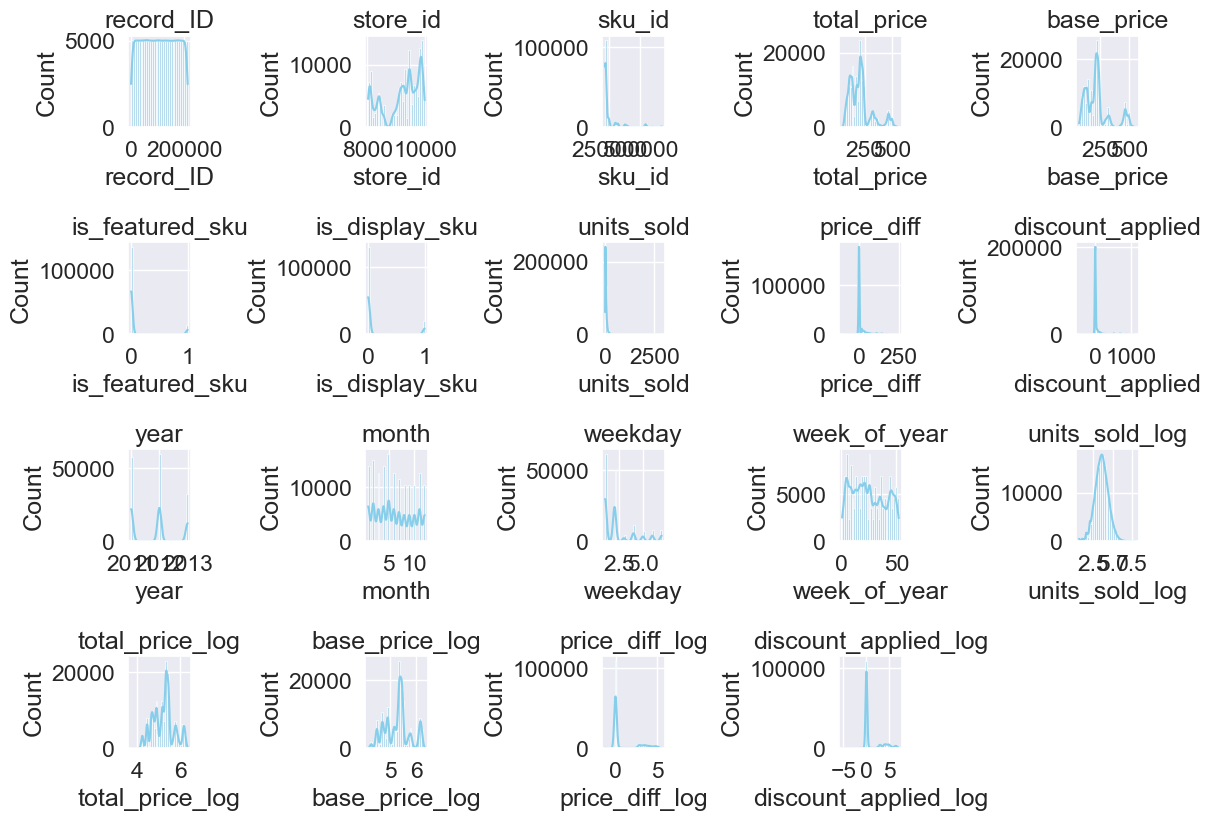

In [189]:
num = train.select_dtypes(include='number')
num1 = num.copy()

plt.figure(figsize=(12,10))

for i, column in enumerate(num1, 1):
    plt.subplot(5, 5, i)
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()


In [190]:
from sklearn.preprocessing import PowerTransformer

cols_to_transform = ['price_diff', 'discount_applied']

pt = PowerTransformer(method='yeo-johnson')

transformed_train = pt.fit_transform(train[cols_to_transform])

transformed_test = pt.fit_transform(test[cols_to_transform])


for i, col in enumerate(cols_to_transform):
    train[f'{col}_yj'] = transformed_train[:, i]
    test[f'{col}_yj'] = transformed_test[:, i]

print(train, test)


        record_ID       date  store_id  sku_id  total_price  base_price  \
0               1 2011-01-17      8091  216418      99.0375    111.8625   
1               2 2011-01-17      8091  216419      99.0375     99.0375   
2               3 2011-01-17      8091  216425     133.9500    133.9500   
3               4 2011-01-17      8091  216233     133.9500    133.9500   
4               5 2011-01-17      8091  217390     141.0750    141.0750   
...           ...        ...       ...     ...          ...         ...   
150145     212638 2013-09-07      9984  223245     235.8375    235.8375   
150146     212639 2013-09-07      9984  223153     235.8375    235.8375   
150147     212642 2013-09-07      9984  245338     357.6750    483.7875   
150148     212643 2013-09-07      9984  547934     141.7875    191.6625   
150149     212644 2013-09-07      9984  679023     234.4125    234.4125   

        is_featured_sku  is_display_sku  units_sold  price_diff  ...  month  \
0                   

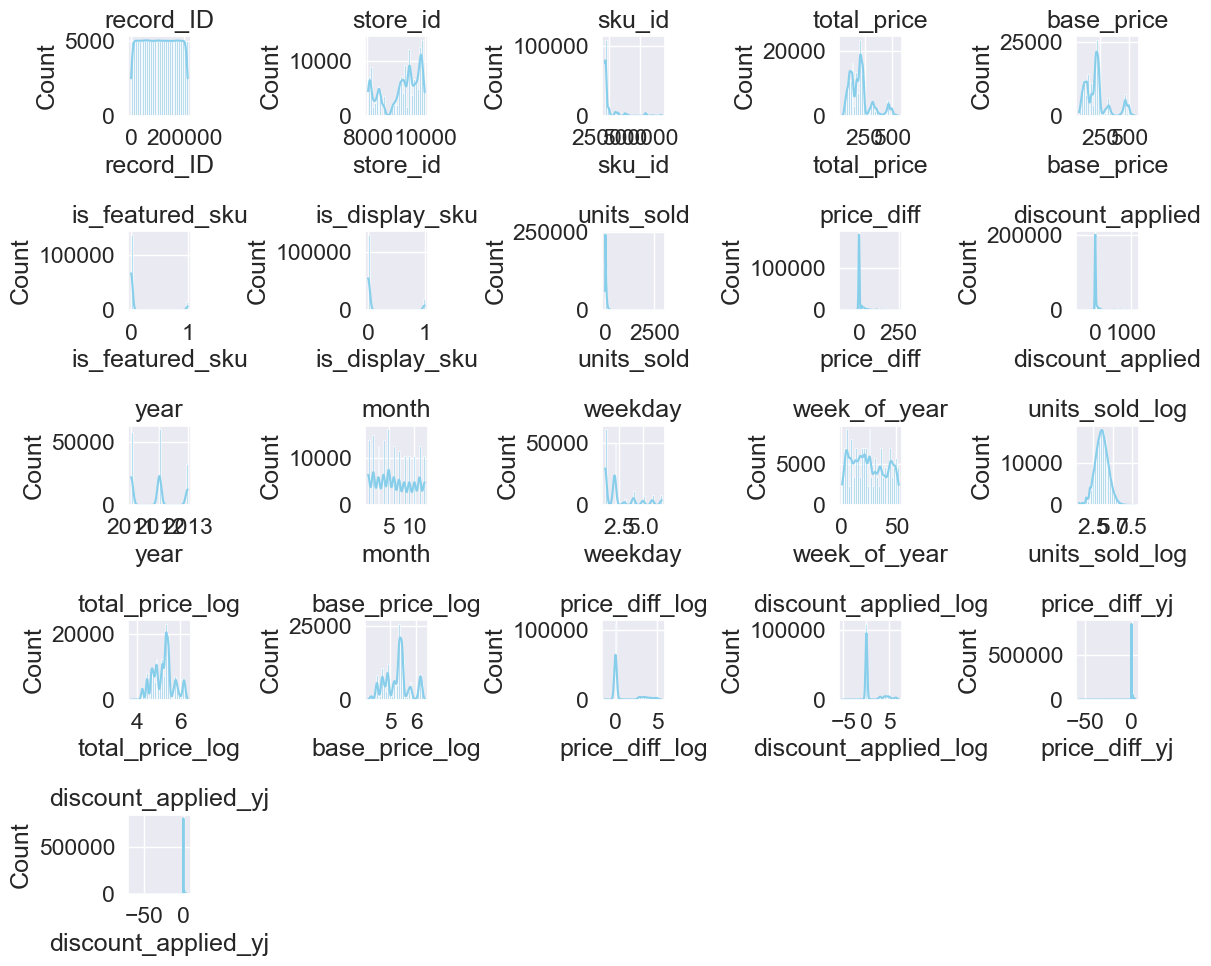

In [191]:
num = train.select_dtypes(include='number')
num1 = num.copy()

plt.figure(figsize=(12,10))

for i, column in enumerate(num1, 1):
    plt.subplot(5, 5, i)
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()


In [192]:
train[['price_diff_yj', 'discount_applied_yj']].skew()

price_diff_yj         -10.447964
discount_applied_yj   -17.482093
dtype: float64

Too much left skew and it might hurt model performance. Different approach required to normalize the distribution.

In [193]:
train['price_diff_cbrt'] = np.cbrt(train['price_diff'])
train['discount_applied_cbrt'] = np.cbrt(train['discount_applied'])

test['price_diff_cbrt'] = np.cbrt(test['price_diff'])
test['discount_applied_cbrt'] = np.cbrt(test['discount_applied'])

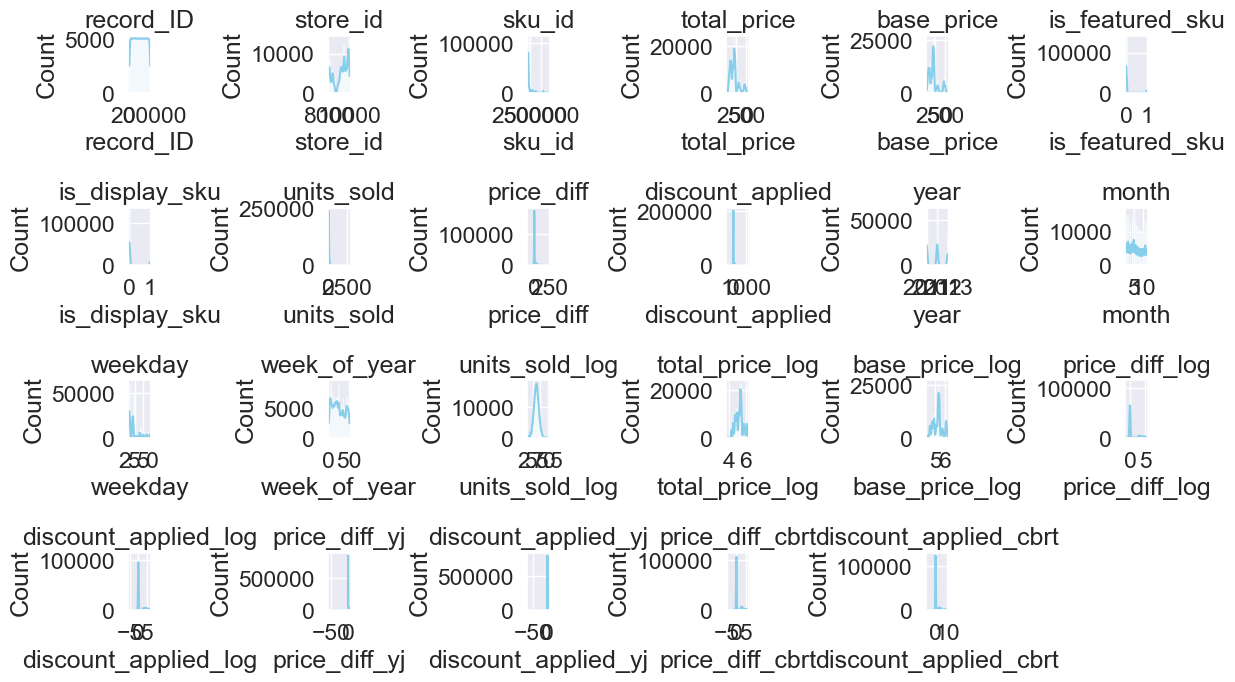

In [194]:
num = train.select_dtypes(include='number')
num1 = num.copy()

plt.figure(figsize=(12,10))

for i, column in enumerate(num1, 1):
    plt.subplot(6, 6, i)
    sns.histplot(train[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()


In [195]:
train[['price_diff_cbrt', 'discount_applied_cbrt']].skew()

price_diff_cbrt          1.409143
discount_applied_cbrt    1.850051
dtype: float64

In [196]:
train['store_id'].nunique()

76

In [197]:
train_dummies = pd.get_dummies(train, columns=['store_id'])

test_dummies = pd.get_dummies(test, columns=['store_id'])

test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value= 0)

In [198]:
train_dummies

,record_ID,date,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,price_diff,discount_applied,...,store_id_9872,store_id_9876,store_id_9879,store_id_9880,store_id_9881,store_id_9890,store_id_9909,store_id_9954,store_id_9961,store_id_9984
0,1,2011-01-17,216418,99.0375,111.8625,0,0,20,12.8250,14.346366,...,False,False,False,False,False,False,False,False,False,False
1,2,2011-01-17,216419,99.0375,99.0375,0,0,28,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,False
2,3,2011-01-17,216425,133.9500,133.9500,0,0,19,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,False
3,4,2011-01-17,216233,133.9500,133.9500,0,0,44,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,False
4,5,2011-01-17,217390,141.0750,141.0750,0,0,52,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,223245,235.8375,235.8375,0,0,38,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,True
150146,212639,2013-09-07,223153,235.8375,235.8375,0,0,30,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,True
150147,212642,2013-09-07,245338,357.6750,483.7875,1,1,31,126.1125,610.116511,...,False,False,False,False,False,False,False,False,False,True
150148,212643,2013-09-07,547934,141.7875,191.6625,0,1,12,49.8750,95.591672,...,False,False,False,False,False,False,False,False,False,True


In [199]:
train = train_dummies.copy()
test = test_dummies.copy()

train

,record_ID,date,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,price_diff,discount_applied,...,store_id_9872,store_id_9876,store_id_9879,store_id_9880,store_id_9881,store_id_9890,store_id_9909,store_id_9954,store_id_9961,store_id_9984
0,1,2011-01-17,216418,99.0375,111.8625,0,0,20,12.8250,14.346366,...,False,False,False,False,False,False,False,False,False,False
1,2,2011-01-17,216419,99.0375,99.0375,0,0,28,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,False
2,3,2011-01-17,216425,133.9500,133.9500,0,0,19,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,False
3,4,2011-01-17,216233,133.9500,133.9500,0,0,44,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,False
4,5,2011-01-17,217390,141.0750,141.0750,0,0,52,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,223245,235.8375,235.8375,0,0,38,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,True
150146,212639,2013-09-07,223153,235.8375,235.8375,0,0,30,0.0000,0.000000,...,False,False,False,False,False,False,False,False,False,True
150147,212642,2013-09-07,245338,357.6750,483.7875,1,1,31,126.1125,610.116511,...,False,False,False,False,False,False,False,False,False,True
150148,212643,2013-09-07,547934,141.7875,191.6625,0,1,12,49.8750,95.591672,...,False,False,False,False,False,False,False,False,False,True


In [200]:
train['sku_id'].nunique()

28

In [201]:
train_dummies = pd.get_dummies(train, columns=['sku_id'])

test_dummies = pd.get_dummies(test, columns=['sku_id'])

test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value= 0)

In [202]:
train_dummies

,record_ID,date,total_price,base_price,is_featured_sku,is_display_sku,units_sold,price_diff,discount_applied,store_sku,...,sku_id_320485,sku_id_327492,sku_id_378934,sku_id_398721,sku_id_545621,sku_id_546789,sku_id_547934,sku_id_600934,sku_id_673209,sku_id_679023
0,1,2011-01-17,99.0375,111.8625,0,0,20,12.8250,14.346366,8091_216418,...,False,False,False,False,False,False,False,False,False,False
1,2,2011-01-17,99.0375,99.0375,0,0,28,0.0000,0.000000,8091_216419,...,False,False,False,False,False,False,False,False,False,False
2,3,2011-01-17,133.9500,133.9500,0,0,19,0.0000,0.000000,8091_216425,...,False,False,False,False,False,False,False,False,False,False
3,4,2011-01-17,133.9500,133.9500,0,0,44,0.0000,0.000000,8091_216233,...,False,False,False,False,False,False,False,False,False,False
4,5,2011-01-17,141.0750,141.0750,0,0,52,0.0000,0.000000,8091_217390,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,235.8375,235.8375,0,0,38,0.0000,0.000000,9984_223245,...,False,False,False,False,False,False,False,False,False,False
150146,212639,2013-09-07,235.8375,235.8375,0,0,30,0.0000,0.000000,9984_223153,...,False,False,False,False,False,False,False,False,False,False
150147,212642,2013-09-07,357.6750,483.7875,1,1,31,126.1125,610.116511,9984_245338,...,False,False,False,False,False,False,False,False,False,False
150148,212643,2013-09-07,141.7875,191.6625,0,1,12,49.8750,95.591672,9984_547934,...,False,False,False,False,False,False,True,False,False,False


In [203]:
train = train_dummies.copy()
test = test_dummies.copy()

In [204]:
#moving the target on the right

sales_placeholder = train.pop('units_sold')

train['units_sold'] = sales_placeholder

train

,record_ID,date,total_price,base_price,is_featured_sku,is_display_sku,price_diff,discount_applied,store_sku,year,...,sku_id_327492,sku_id_378934,sku_id_398721,sku_id_545621,sku_id_546789,sku_id_547934,sku_id_600934,sku_id_673209,sku_id_679023,units_sold
0,1,2011-01-17,99.0375,111.8625,0,0,12.8250,14.346366,8091_216418,2011,...,False,False,False,False,False,False,False,False,False,20
1,2,2011-01-17,99.0375,99.0375,0,0,0.0000,0.000000,8091_216419,2011,...,False,False,False,False,False,False,False,False,False,28
2,3,2011-01-17,133.9500,133.9500,0,0,0.0000,0.000000,8091_216425,2011,...,False,False,False,False,False,False,False,False,False,19
3,4,2011-01-17,133.9500,133.9500,0,0,0.0000,0.000000,8091_216233,2011,...,False,False,False,False,False,False,False,False,False,44
4,5,2011-01-17,141.0750,141.0750,0,0,0.0000,0.000000,8091_217390,2011,...,False,False,False,False,False,False,False,False,False,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-09-07,235.8375,235.8375,0,0,0.0000,0.000000,9984_223245,2013,...,False,False,False,False,False,False,False,False,False,38
150146,212639,2013-09-07,235.8375,235.8375,0,0,0.0000,0.000000,9984_223153,2013,...,False,False,False,False,False,False,False,False,False,30
150147,212642,2013-09-07,357.6750,483.7875,1,1,126.1125,610.116511,9984_245338,2013,...,False,False,False,False,False,False,False,False,False,31
150148,212643,2013-09-07,141.7875,191.6625,0,1,49.8750,95.591672,9984_547934,2013,...,False,False,False,False,False,True,False,False,False,12


In [205]:
train.columns

Index(['record_ID', 'date', 'total_price', 'base_price', 'is_featured_sku',
       'is_display_sku', 'price_diff', 'discount_applied', 'store_sku', 'year',
       ...
       'sku_id_327492', 'sku_id_378934', 'sku_id_398721', 'sku_id_545621',
       'sku_id_546789', 'sku_id_547934', 'sku_id_600934', 'sku_id_673209',
       'sku_id_679023', 'units_sold'],
      dtype='object', length=127)

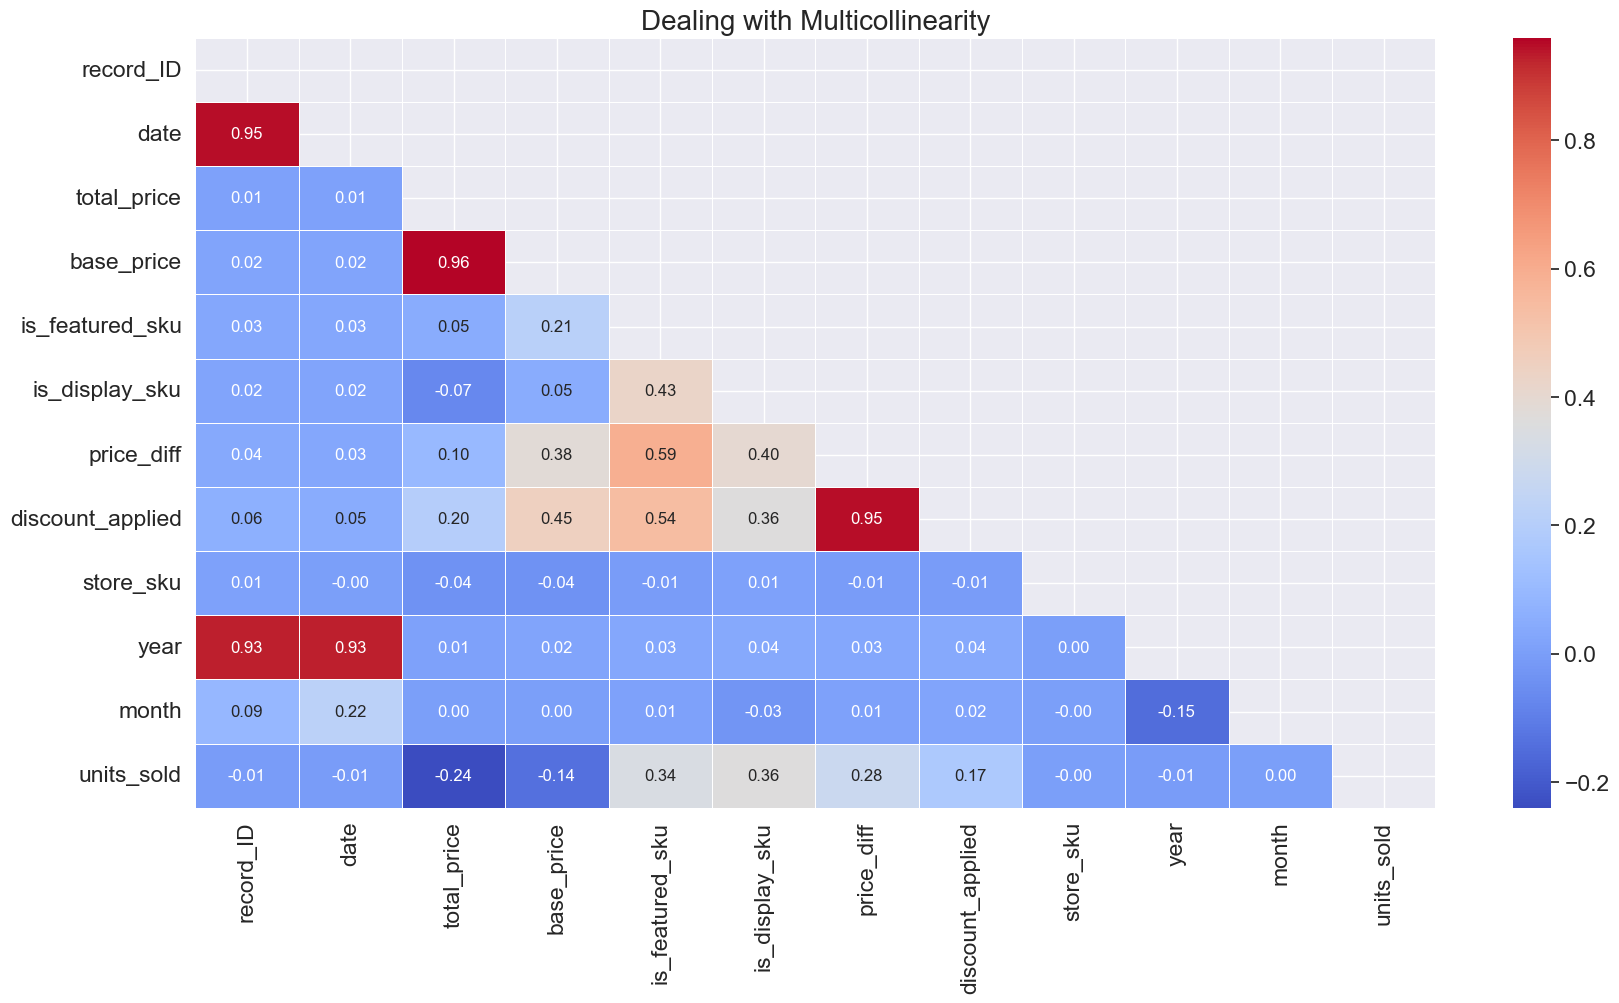

In [206]:
col_correlation = ['record_ID', 'date', 'total_price', 'base_price', 'is_featured_sku',
       'is_display_sku', 'price_diff', 'discount_applied', 'store_sku', 'year', 'month', 'units_sold']

num_corr = round(train[col_correlation].corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Dealing with Multicollinearity", fontsize=20) # add title
plt.show()


In [207]:
train.shape

(150150, 127)

In [208]:
train = train.dropna()

In [209]:
train.shape

(147576, 127)

In [210]:
print(list(train.columns))

['record_ID', 'date', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku', 'price_diff', 'discount_applied', 'store_sku', 'year', 'month', 'weekday', 'week_of_year', 'units_sold_log', 'total_price_log', 'base_price_log', 'price_diff_log', 'discount_applied_log', 'price_diff_yj', 'discount_applied_yj', 'price_diff_cbrt', 'discount_applied_cbrt', 'store_id_8023', 'store_id_8058', 'store_id_8063', 'store_id_8091', 'store_id_8094', 'store_id_8095', 'store_id_8121', 'store_id_8218', 'store_id_8222', 'store_id_8317', 'store_id_8319', 'store_id_8392', 'store_id_8398', 'store_id_8400', 'store_id_8422', 'store_id_8438', 'store_id_8555', 'store_id_8562', 'store_id_8869', 'store_id_8911', 'store_id_8991', 'store_id_9001', 'store_id_9043', 'store_id_9092', 'store_id_9112', 'store_id_9132', 'store_id_9147', 'store_id_9164', 'store_id_9178', 'store_id_9190', 'store_id_9221', 'store_id_9250', 'store_id_9273', 'store_id_9279', 'store_id_9281', 'store_id_9328', 'store_id_9371', 'store_id_9

In [211]:
train = train.drop(columns='date')

In [212]:
train = train.drop(columns=['price_diff_yj', 'store_sku', 'record_ID','discount_applied_yj', 'price_diff_log', 'discount_applied_log' , 'price_diff', 'discount_applied', 'base_price', 'total_price', 'units_sold'])
test = test.drop(columns=['date', 'record_ID', 'store_sku', 'price_diff_yj', 'discount_applied_yj', 'price_diff_log', 'discount_applied_log' , 'price_diff', 'discount_applied', 'base_price', 'total_price', 'units_sold'])

In [213]:
print(list(train.columns))

['is_featured_sku', 'is_display_sku', 'year', 'month', 'weekday', 'week_of_year', 'units_sold_log', 'total_price_log', 'base_price_log', 'price_diff_cbrt', 'discount_applied_cbrt', 'store_id_8023', 'store_id_8058', 'store_id_8063', 'store_id_8091', 'store_id_8094', 'store_id_8095', 'store_id_8121', 'store_id_8218', 'store_id_8222', 'store_id_8317', 'store_id_8319', 'store_id_8392', 'store_id_8398', 'store_id_8400', 'store_id_8422', 'store_id_8438', 'store_id_8555', 'store_id_8562', 'store_id_8869', 'store_id_8911', 'store_id_8991', 'store_id_9001', 'store_id_9043', 'store_id_9092', 'store_id_9112', 'store_id_9132', 'store_id_9147', 'store_id_9164', 'store_id_9178', 'store_id_9190', 'store_id_9221', 'store_id_9250', 'store_id_9273', 'store_id_9279', 'store_id_9281', 'store_id_9328', 'store_id_9371', 'store_id_9425', 'store_id_9430', 'store_id_9432', 'store_id_9436', 'store_id_9439', 'store_id_9442', 'store_id_9456', 'store_id_9479', 'store_id_9481', 'store_id_9490', 'store_id_9498', 'st

## Baseline Model

In [214]:
#regression issues

def train_and_eval_models(X_train, X_test, y_train, y_test):

    #models to test
    models = {
        "Linear Regression" : LinearRegression(),
        "Random Forest" : RandomForestRegressor(),
        "XGB" : XGBRegressor()
    }

    print("Starting the training process.")

    #list to store results

    results = []

    for name, model in models.items():
        print(f"Training model: {name}")

        model.fit(X_train, y_train)

        y_train_predict = model.predict(X_train)
        y_test_predict = model.predict(X_test)

        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_train_predict),
            "Test MAE": mean_absolute_error(y_test, y_test_predict),
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_predict)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_predict)),
            "Train R2": r2_score(y_train, y_train_predict),
            "Test R2": r2_score(y_test, y_test_predict)
        })

    # Converting results into a DataFrame
    results_df = pd.DataFrame(results)

    print("\nModel Performance Summary:")
    print(results_df)

    return results_df, model


In [215]:
X = train.drop(columns='units_sold_log')
y = train['units_sold_log']

In [218]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

In [219]:
import pickle

baseline_df, baseline_model = train_and_eval_models(X_train, X_test, y_train, y_test)

print(baseline_df)

#Saving the baseline model

with open('baseline_model.pkl', 'wb') as file:
    pickle.dump(baseline_model, file)

print("Model saved successfully to 'baseline_model.pkl'")


Starting the training process.
Training model: Linear Regression
Training model: Random Forest
Training model: XGB

Model Performance Summary:
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   0.401580  0.398927    0.523759   0.520049  0.627407   
1      Random Forest   0.105524  0.285195    0.143561   0.382236  0.972007   
2                XGB   0.292842  0.303751    0.386188   0.400216  0.797433   

    Test R2  
0  0.629803  
1  0.800010  
2  0.780753  
               Model  Train MAE  Test MAE  Train RMSE  Test RMSE  Train R2  \
0  Linear Regression   0.401580  0.398927    0.523759   0.520049  0.627407   
1      Random Forest   0.105524  0.285195    0.143561   0.382236  0.972007   
2                XGB   0.292842  0.303751    0.386188   0.400216  0.797433   

    Test R2  
0  0.629803  
1  0.800010  
2  0.780753  
Model saved successfully to 'baseline_model.pkl'


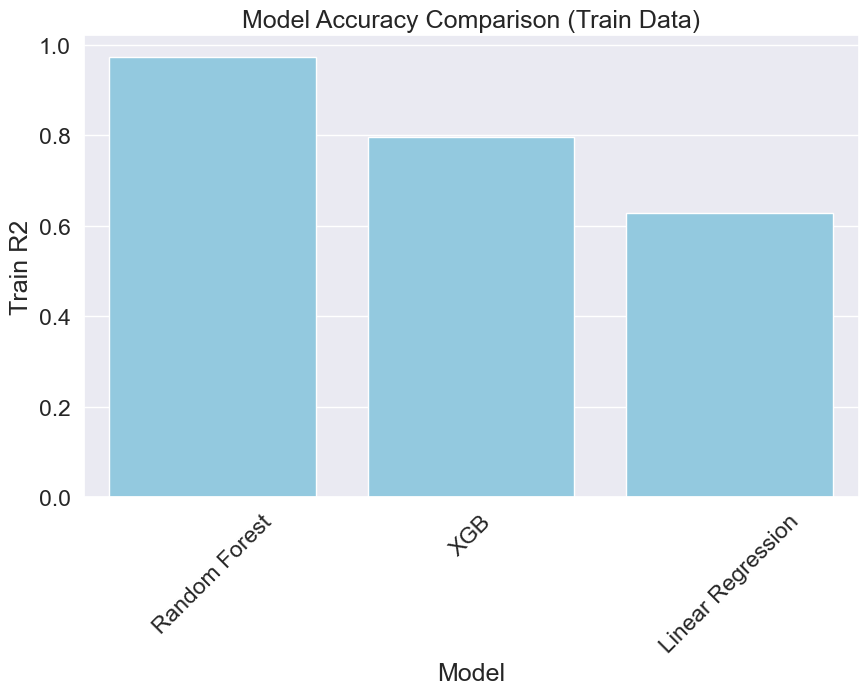

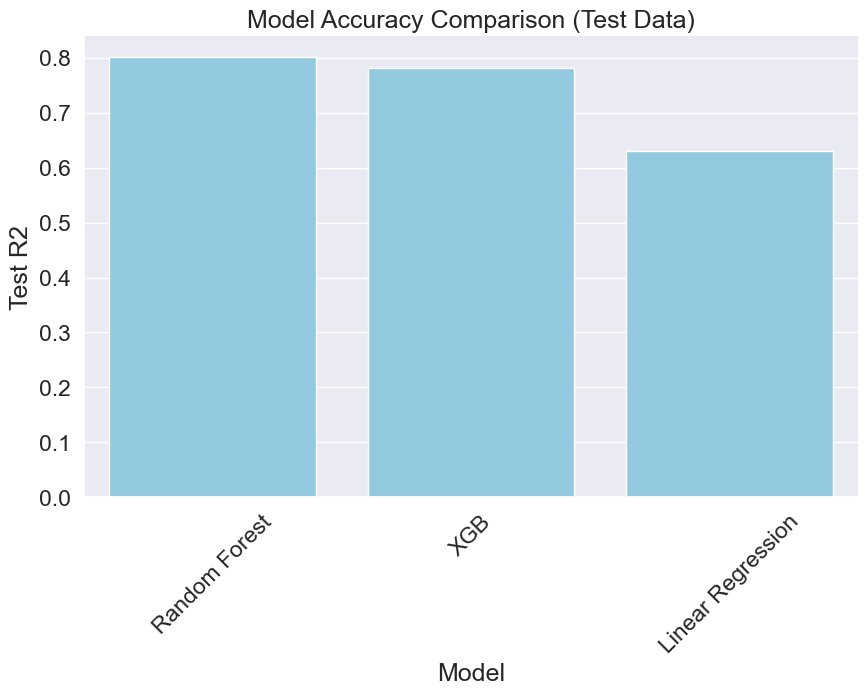

In [221]:
#plotting the results

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Train R2", data=baseline_df.sort_values(by='Train R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Train Data)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Test R2", data=baseline_df.sort_values(by='Test R2', ascending=False), color='skyblue')
plt.title("Model Accuracy Comparison (Test Data)")
plt.xticks(rotation=45)
plt.show()


Best performance reached by RandomForest but probably overfitting, XGB reaching a 78% precision. Further feature engineering required to improve model performance.